# Use Case 2 - Wildfires in Catalonia, Spain

## Introduction 

Wildfires are complex, dynamic phenomena driven by an intricate mix of long-term climate trends, daily weather extremes, and localised landscape features. The purpose of this notebook is to explore how these **meteorological** and **biophysical** variables interact to dictate **wildfire behaviour, size, and frequency**. Focusing on the region of Catalonia, Spain, this analysis integrates several layers of data to build a complete picture of fire events:

- Historical Fire Catalogs from 1986 to 2023

- Meteorological & Climate database extracted from ERA5-Reanalysis

- High-resolution raster datasets capturing biomass, land cover types and Digital Elevation Models (DEM)


This case study is structured as an analytical funnel with the following sections:

1. Configuration & Data

2. Historical Fires Characterisation

3. Macro-level Fire Correlations with Meteo Variables

4. Fire-event level: Meteo variables for different fire events

5. Influence of Nature in Fires


In [4]:
# HIDE CODE

import geopandas as gpd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import pandas as pd
import xarray as xr
import numpy as np
import seaborn as sns
import plotly.express as px
import rasterio
import rioxarray
from scipy.stats import pearsonr
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

We load the historical wildfire catalog for Catalonia (1986–2023) sourced from the **Institut Cartogràfic i Geològic de Catalunya (ICGC)**. For every unique fire (`fire_id`), each row provides:

- Spatial Data: The fire's perimeter (geometry) and the coordinates of its centroid.

- Observed Meteorology: Weather conditions on the exact date of the fire, extracted at the centroid. This data is extracted from **ERA5-Reanalysis**.

- Climatological Baseline: The historical average conditions for that specific day of the year (using the 1981–2000 reference period), labeled with a *_clim* suffix. This structure allows us to easily calculate and analyze weather anomalies.

```{warning}
**Download Time Expected!**
Running this cell fetches data directly from the Zenodo research repository. Depending on your internet speed, **this may take a minute or two to download and load the GeoJSON file into your notebook's memory.** Please do not interrupt the kernel while it is fetching the data.
```

In [16]:
fires = gpd.read_file(
    "https://zenodo.org/records/18770754/files/fires_CAT_with_meteo.geojson"
    )

print(f"Columns: {fires.columns.tolist()}")
fires.iloc[:, 0:7].head()

Columns: ['date', 'area', 'lon', 'lat', 'year', 'month', 'fire_id', 'area_ha', 'pr', 'tas', 'hurs', 'wind', 'windmax', 'vpd', 'fwi', 'spei3', 'spei12', 'spei12_lagged', 'pr_anomaly', 'tas_anomaly', 'hurs_anomaly', 'wind_anomaly', 'windmax_anomaly', 'vpd_anomaly', 'fwi_anomaly', 'pr_clim', 'tas_clim', 'hurs_clim', 'wind_clim', 'windmax_clim', 'vpd_clim', 'fwi_clim', 'spei3_clim', 'spei12_clim', 'spei12_lagged_clim', 'pr_anomaly_clim', 'tas_anomaly_clim', 'hurs_anomaly_clim', 'wind_anomaly_clim', 'windmax_anomaly_clim', 'vpd_anomaly_clim', 'fwi_anomaly_clim', 'geometry']


,date,area,lon,lat,year,month,fire_id
0,1986-07-19,2.795379e+08,2.972878,42.398173,1986,7,0
1,1998-07-18,2.753549e+08,1.547005,41.824862,1998,7,1
2,2012-07-22,1.921472e+08,2.889306,42.359151,2012,7,2
3,1994-08-10,1.630026e+08,2.594465,41.785177,1994,8,3
4,1998-07-19,1.568074e+08,1.562088,41.932784,1998,7,4


This dataset includes several specific meteorological variables, drought indices, and their variations. Here is a breakdown of what each abbreviation means:

**Core Weather Variables (Observed at the time of the fire)**

- pr: Precipitation (Rainfall amount).

- tas: Near-surface air temperature.

- hurs: Near-surface relative humidity.

- wind: Average wind speed.

- windmax: Maximum wind speed (gusts).

- vpd: Vapor Pressure Deficit. This measures the difference between the amount of moisture in the air and how much moisture the air can hold when saturated. Higher VPD means the air is aggressively pulling moisture out of the vegetation (drying out the fuel).

**Fire and Drought Indices**

- fwi: Fire Weather Index. A comprehensive numeric rating of fire danger based on weather observations.

- spei3: 3-month Standardized Precipitation Evapotranspiration Index. Measures short-term drought conditions.

- spei12: 12-month SPEI. Measures long-term drought conditions.

- spei12_lagged: The 12-month SPEI from a previous period. This is often used to analyze how historical long-term drought "pre-conditioned" the vegetation before the fire season started.

**Column Suffixes**

To analyze how abnormal the weather was during a fire, the dataset includes these modifiers for the variables above:

- [variable]_clim: The climatological baseline. This is the expected, historical average for that specific day of the year, calculated using the 1981–2000 reference period.

- [variable]_anomaly: The deviation from the norm (usually calculated as Observed - Climatology). Positive temperature anomalies or negative precipitation anomalies often correlate with higher fire danger.

## 2. Historical Fires Characterisation

### 2.1. Map of all historical fires in Catalonia between 1985 and 2023

We explore the historical wildfires dataset by geographical distribution, pattern and size. 

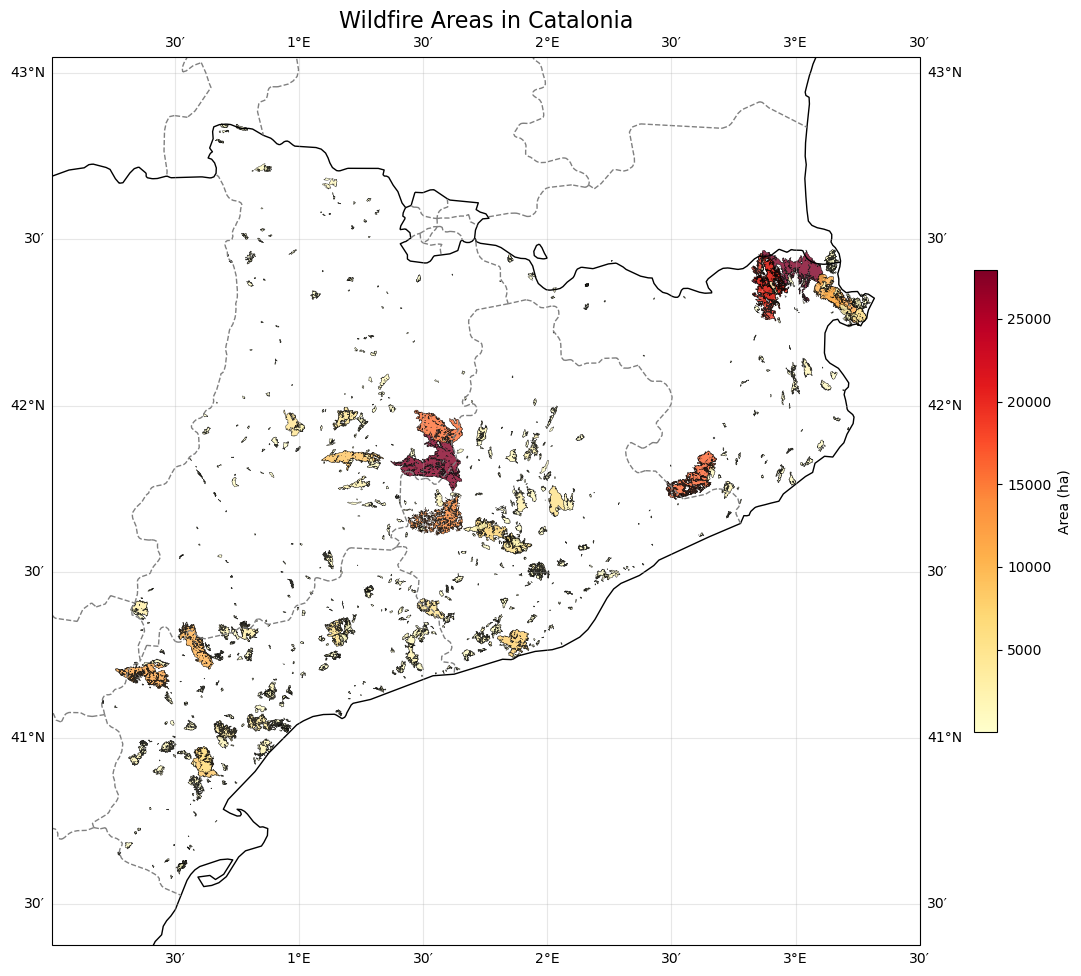

In [17]:
# Setup the Map Projection
fig = plt.figure(figsize=(14, 12))  # Made figure slightly larger
ax = plt.axes(projection=ccrs.PlateCarree())

# Add Geographic Context
# Coastlines and national borders
ax.add_feature(cfeature.COASTLINE, linewidth=1)
ax.add_feature(cfeature.BORDERS, linewidth=1)

# Add Province/Regional borders (This will show the outline of Catalonia)
states_provinces = cfeature.NaturalEarthFeature(
    category="cultural",
    name="admin_1_states_provinces_lines",
    scale="10m",
    facecolor="none",
)

ax.add_feature(states_provinces, edgecolor="gray", linewidth=1.0, linestyle="--")

# Plot the Fires with Outlines
fires.plot(
    ax=ax,
    column="area_ha",
    cmap="YlOrRd",
    legend=True,
    alpha=0.8,
    edgecolor="black",  # The border color for each fire
    linewidth=0.3,  # Keep it thin so it doesn't look messy
    transform=ccrs.PlateCarree(),
    legend_kwds={"label": "Area (ha)", "shrink": 0.5},
)

# Zoom to Catalonia
bounds = fires.total_bounds
margin = 0.2  # Add a small buffer around the data
ax.set_extent(
    [bounds[0] - margin, bounds[2] + margin, bounds[1] - margin, bounds[3] + margin],
    crs=ccrs.PlateCarree(),
)

# Titles and Labels
ax.set_title("Wildfire Areas in Catalonia", fontsize=16)
ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False, alpha=0.3)

plt.show()

### 2.2. Annual Evolution of Fires

To analyse the temporal evolution of wildfire characteristics in Catalonia, four variables are studied:

- Total of area burned by the fires (in hectares)

- Average size of fire events (in hectares)

- Number of fires

- Percentage of area burned by large fires (>1000 ha)


The data illustrates a **shift after the severe wildfires of 1994**; the subsequent implementation of an action plan and improved forest management successfully reduced fire risks, leading to a noticeable **decrease in the average size of fires**.

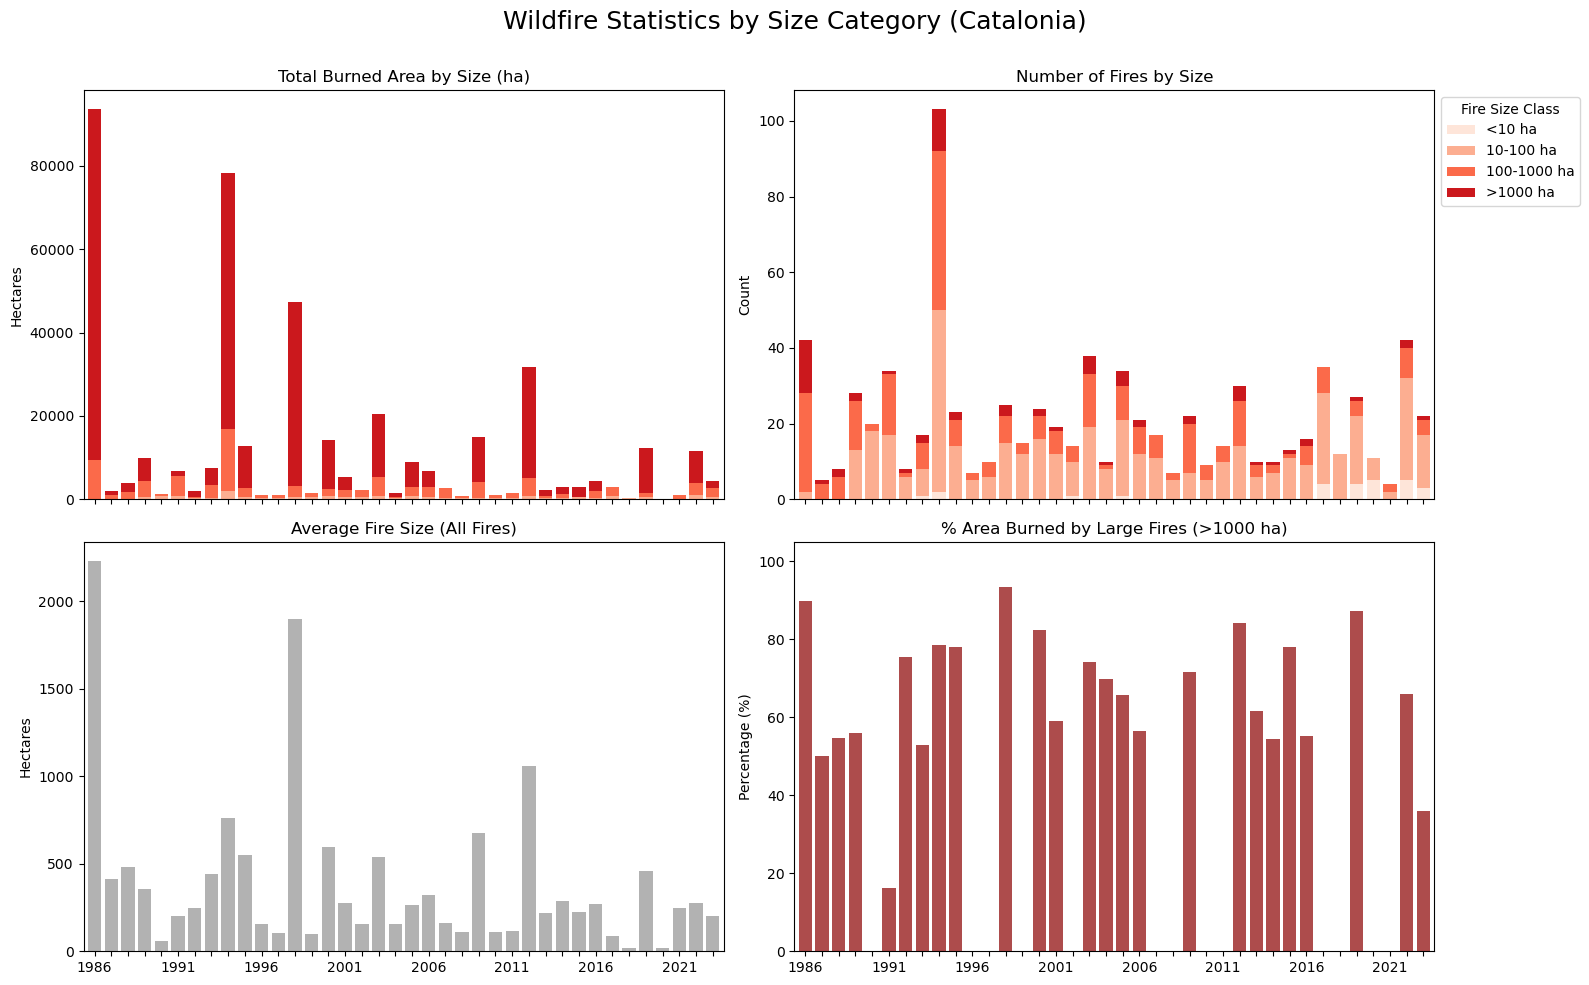

In [18]:
# Setup Categories (Bins)
bins = [0, 10, 100, 1000, float("inf")]
labels = ["<10 ha", "10-100 ha", "100-1000 ha", ">1000 ha"]
fires["size_cat"] = pd.cut(fires["area_ha"], bins=bins, labels=labels)
colors = ["#fee5d9", "#fcae91", "#fb6a4a", "#cb181d"]  # Sequential reds

# Prepare Pivot Tables for Stacked Plots
area_pivot = fires.pivot_table(
    index="year", columns="size_cat", values="area_ha", aggfunc="sum", observed=False
).fillna(0)

count_pivot = fires.pivot_table(
    index="year", columns="size_cat", values="area_ha", aggfunc="count", observed=False
).fillna(0)

# Calculate the standard metrics for the bottom row
yearly_stats = (
    fires.groupby("year", observed=False)
    .agg(total_area_ha=("area_ha", "sum"), avg_size=("area_ha", "mean"))
    .reset_index()
)

large_area = (
    fires[fires["area_ha"] > 1000].groupby("year")["area_ha"].sum().reset_index()
)
yearly_stats = yearly_stats.merge(large_area, on="year", how="left").fillna(0)
yearly_stats["pct_large"] = (
    yearly_stats["area_ha"] / yearly_stats["total_area_ha"]
) * 100

fig, axes = plt.subplots(2, 2, figsize=(16, 10), sharex=True)
fig.suptitle("Wildfire Statistics by Size Category (Catalonia)", fontsize=18)

# Plot 1: STACKED Total Burned Area
area_pivot.plot(
    kind="bar", stacked=True, ax=axes[0, 0], color=colors, legend=False, width=0.8
)
axes[0, 0].set_title("Total Burned Area by Size (ha)")
axes[0, 0].set_ylabel("Hectares")

# Plot 2: STACKED Number of Fires
count_pivot.plot(kind="bar", stacked=True, ax=axes[0, 1], color=colors, width=0.8)
axes[0, 1].set_title("Number of Fires by Size")
axes[0, 1].set_ylabel("Count")
axes[0, 1].legend(title="Fire Size Class", loc="upper left", bbox_to_anchor=(1, 1))

# Plot 3: Average Size (Simple Bar)
axes[1, 0].bar(
    yearly_stats["year"].astype(str), yearly_stats["avg_size"], color="grey", alpha=0.6
)
axes[1, 0].set_title("Average Fire Size (All Fires)")
axes[1, 0].set_ylabel("Hectares")

# Plot 4: % Burned by Large Fires (Simple Bar)
axes[1, 1].bar(
    yearly_stats["year"].astype(str),
    yearly_stats["pct_large"],
    color="darkred",
    alpha=0.7,
)
axes[1, 1].set_title("% Area Burned by Large Fires (>1000 ha)")
axes[1, 1].set_ylabel("Percentage (%)")
axes[1, 1].set_ylim(0, 105)

for ax in axes[1, :]:
    # Set labels to rotate for readability
    ax.tick_params(axis="x", rotation=0)

    # This tells Matplotlib to only show every 5th label
    n = 5
    ticks = ax.get_xticks()
    labels = [
        yearly_stats["year"].iloc[i] if i % n == 0 else ""
        for i in range(len(yearly_stats))
    ]
    ax.set_xticks(ticks)
    ax.set_xticklabels(labels)

plt.tight_layout()
plt.subplots_adjust(top=0.90)
plt.show()

### 2.3. Seasonality of Fires
We can see a distinct seasonality to wildfires in Catalonia, as the vast majority —and particularly the largest, most devastating ones— are heavily concentrated in the warm and dry summer months.

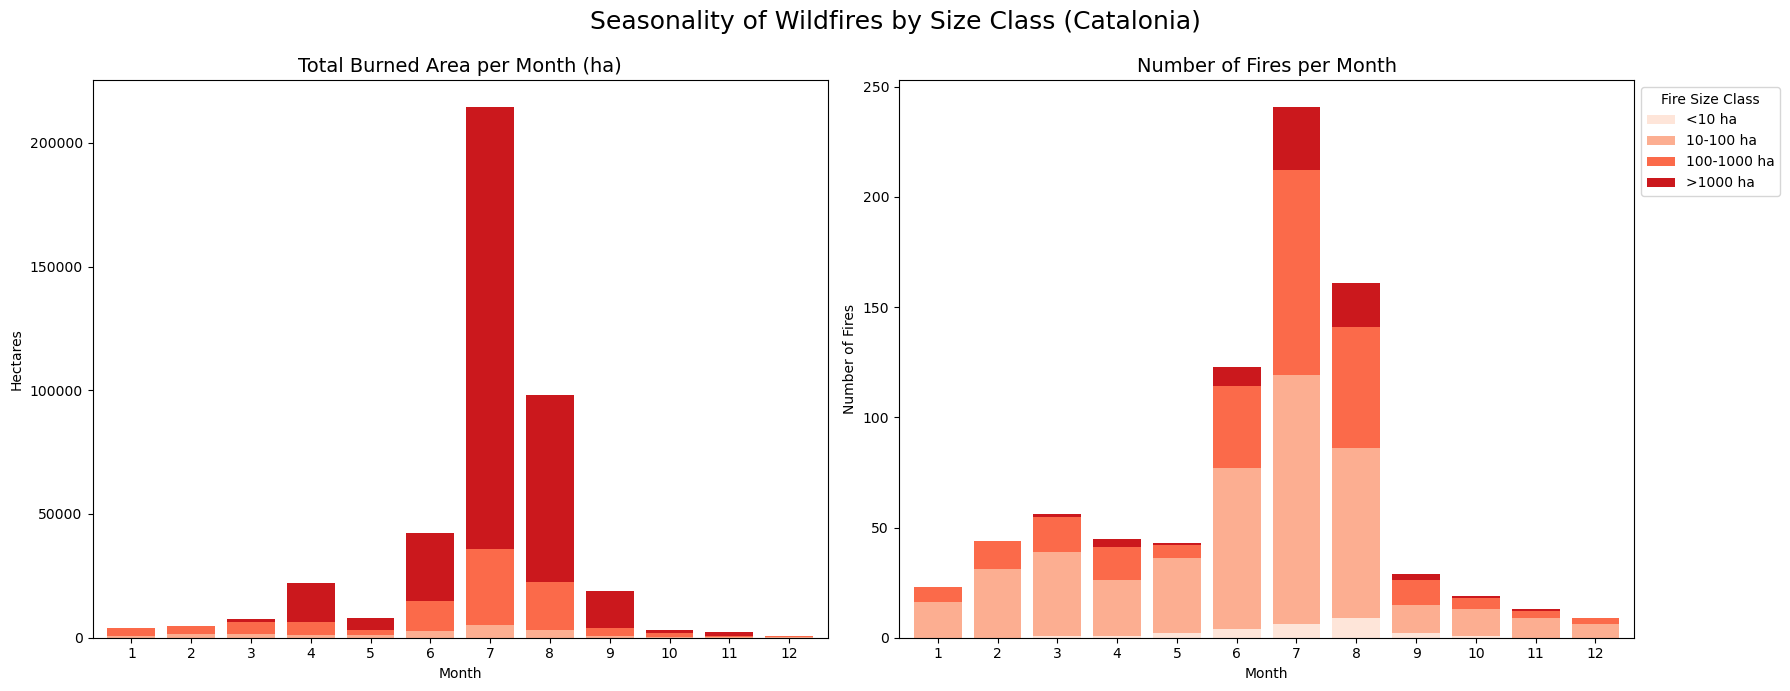

In [19]:
# Prepare Pivot Tables for Monthly Analysis
# Total area summed per month and size category
month_area_pivot = (
    fires.pivot_table(
        index="month",
        columns="size_cat",
        values="area_ha",
        aggfunc="sum",
        observed=False,
    )
    .reindex(range(1, 13))
    .fillna(0)
)

month_count_pivot = (
    fires.pivot_table(
        index="month",
        columns="size_cat",
        values="area_ha",
        aggfunc="count",
        observed=False,
    )
    .reindex(range(1, 13))
    .fillna(0)
)

# Create a side-by-side comparison
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 7))
fig.suptitle("Seasonality of Wildfires by Size Class (Catalonia)", fontsize=18)

# Left Plot: Total Area (Stacked)
month_area_pivot.plot(
    kind="bar", stacked=True, ax=ax1, color=colors, legend=False, width=0.8
)
ax1.set_title("Total Burned Area per Month (ha)", fontsize=14)
ax1.set_ylabel("Hectares")
ax1.set_xlabel("Month")
ax1.set_xticklabels(range(1, 13), rotation=0)

# Right Plot: Frequency of Fires (Stacked)
month_count_pivot.plot(kind="bar", stacked=True, ax=ax2, color=colors, width=0.8)
ax2.set_title("Number of Fires per Month", fontsize=14)
ax2.set_ylabel("Number of Fires")
ax2.set_xlabel("Month")
ax2.set_xticklabels(range(1, 13), rotation=0)
ax2.legend(title="Fire Size Class", loc="upper left", bbox_to_anchor=(1, 1))

plt.tight_layout()
plt.subplots_adjust(top=0.88)
plt.show()

## 3. Macro-level Fire Correlations with Meteo Variables

To analyze the correlation between fire events and meteorological conditions, the dataset is split at the year 1996, marking the implementation of improved fire management policies after the 1994 events.

Comparing the correlation values between both periods reveals that average meteorological conditions are no longer as strict a predictor of the total burned area, thanks to the current management policies for fire control. While drought indicators show the strongest correlation in both eras, the influence of the lagged SPEI-12 notably strengthened after 1996. Its positive correlation suggests a "pre-conditioning" effect: wetter conditions in the preceding year promote increased vegetation growth, which subsequently dries out and acts as abundant fuel for future fires.

Furthermore, when comparing FWI against fire metrics, it is notable that the frequency and size of larger fires no longer mirror the overarching meteorological conditions.

In [20]:
# Define the split year
split_year = 1996

# Define the aggregation dictionary once to avoid repeating it
meteo_agg = {
    "total_area_ha": ("area_ha", "sum"),
    "num_fires": ("area_ha", "count"),
    "avg_fwi": ("fwi", "mean"),
    "avg_hurs": ("hurs", "mean"),
    "avg_vpd": ("vpd", "mean"),
    "avg_spei3": ("spei3", "mean"),
    "avg_spei12": ("spei12", "mean"),
    "avg_spei12_lagged": ("spei12_lagged", "mean"),
    "anom_hurs": ("hurs_anomaly", "mean"),
    "anom_vpd": ("vpd_anomaly", "mean"),
    "anom_fwi": ("fwi_anomaly", "mean"),
    "anom_wind": ("wind_anomaly", "mean"),
}


def get_stats_for_all_time(df_subset):
    # Process the whole dataset
    stats = df_subset.groupby("year").agg(**meteo_agg).reset_index()

    # Calculate % Large fires
    large = (
        df_subset[df_subset["area_ha"] > 1000]
        .groupby("year")["area_ha"]
        .sum()
        .reset_index()
    )
    large.rename(columns={"area_ha": "large_fire_area_ha"}, inplace=True)
    stats = stats.merge(large, on="year", how="left").fillna(0)
    stats["pct_large"] = (stats["large_fire_area_ha"] / stats["total_area_ha"]) * 100
    return stats


# Create the two datasets (continuous timelines)
annual_stats_100 = get_stats_for_all_time(fires[fires["area_ha"] >= 100])
annual_stats_10 = get_stats_for_all_time(fires[fires["area_ha"] < 100])
annual_stats = get_stats_for_all_time(fires)

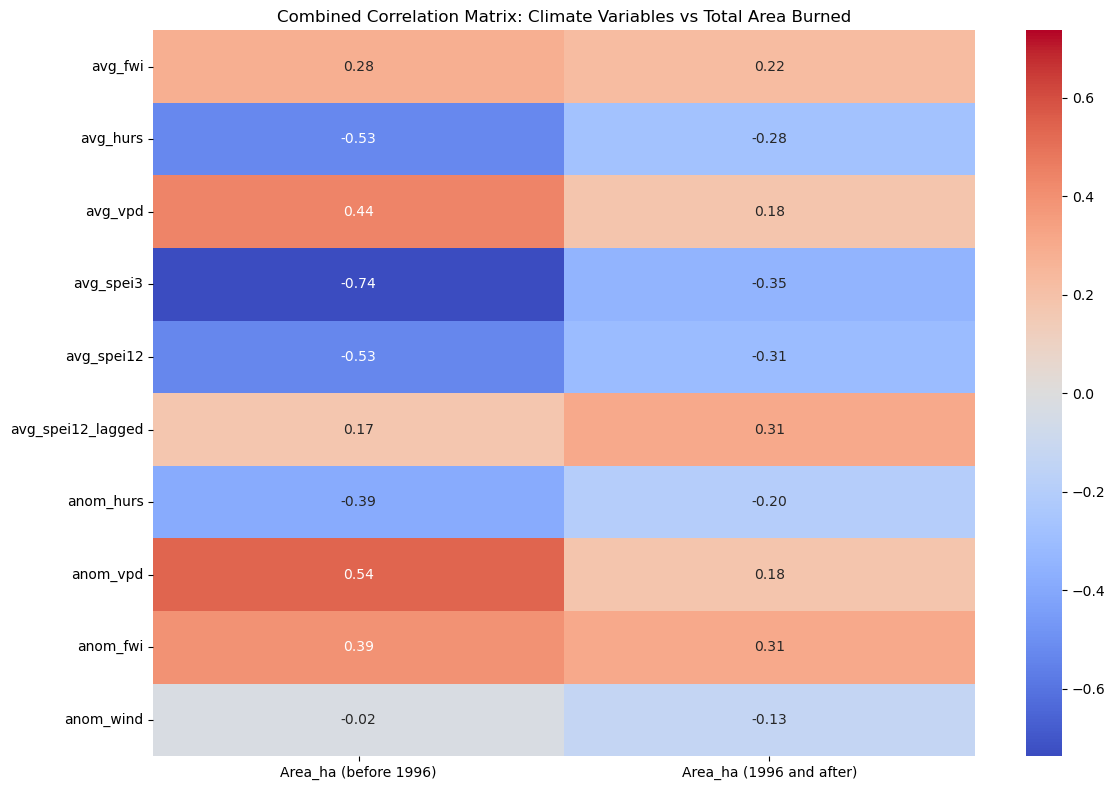

In [21]:
# Correlation calculations
corr1 = annual_stats[annual_stats['year']<1996].corr()[['total_area_ha']]
corr2 = annual_stats[annual_stats['year']>=1996].corr()[['total_area_ha']]

# Rename columns to distinguish between the >=100 ha and >=10 ha datasets
corr1_renamed = corr1.rename(columns={
    'total_area_ha': 'Area_ha (before 1996)', 
})
corr2_renamed = corr2.rename(columns={
    'total_area_ha': 'Area_ha (1996 and after)', 
})

# Concatenate the two dataframes side-by-side
combined_corr = pd.concat([corr1_renamed, corr2_renamed], axis=1)

# Filter to keep only the specified rows
rows_to_plot = [
    'avg_fwi', 'avg_hurs', 'avg_vpd', 'avg_spei3', 'avg_spei12', 
    'avg_spei12_lagged', 'anom_hurs', 'anom_vpd', 'anom_fwi', 'anom_wind'
]
combined_corr = combined_corr.loc[rows_to_plot]

# Find the maximum absolute value for a centered colorbar (calculated on the filtered data)
max_abs_val = combined_corr.abs().max().max()

# Plot the combined heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(
    data=combined_corr, 
    annot=True, 
    cmap='coolwarm', 
    fmt='.2f',
    vmin=-max_abs_val,  # Set minimum to negative max absolute value
    vmax=max_abs_val,   # Set maximum to positive max absolute value
    center=0            # Force the center of the colormap to be 0
)

plt.title('Combined Correlation Matrix: Climate Variables vs Total Area Burned')
plt.tight_layout()
plt.show()

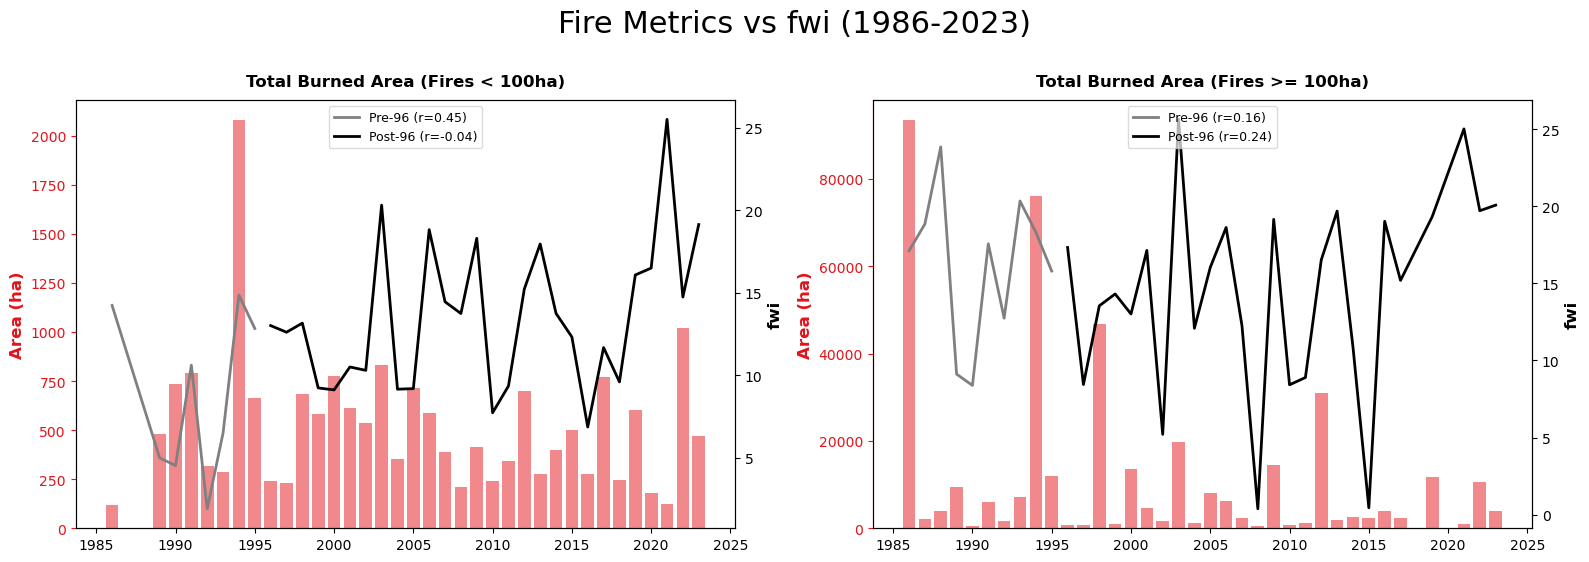

In [40]:
def plot_fwi_vs_metrics_2x2(data_large, data_small, meteo_var="avg_fwi"):
    """
    Creates a 2x2 plot comparing area and fire counts against a single meteo variable.
    """
    fig, axes = plt.subplots(1, 2, figsize=(16, 6), sharex=True)
    fig.suptitle(f"Fire Metrics vs {meteo_agg[meteo_var][0]} (1986-2023)", fontsize=22, y=0.96)

    axes_flat = axes.flatten()

    # Define the 4 subplots: dataset, column to plot, title, and y-axis label
    plot_configs = [
        {"data": data_small, "col": "total_area_ha", "title": "Total Burned Area (Fires < 100ha)", "ylabel": "Area (ha)"},
        {"data": data_large, "col": "total_area_ha", "title": "Total Burned Area (Fires >= 100ha)", "ylabel": "Area (ha)"}
    ]

    bar_color = "#e3131a"

    for i, config in enumerate(plot_configs):
        ax1 = axes_flat[i]
        data = config["data"]
        metric_col = config["col"]

        # 1. Draw Bars (Fire Metric)
        ax1.bar(data["year"], data[metric_col], color=bar_color, alpha=0.5)

        # --- Style Left Y-axis (Red for Fire Data) ---
        ax1.tick_params(axis="y", labelcolor=bar_color, color=bar_color)
        ax1.spines["left"].set_color(bar_color)
        ax1.set_ylabel(config["ylabel"], fontsize=12, fontweight="bold", color=bar_color)
        ax1.set_title(config["title"], fontweight="bold", pad=10)

        # X-axis label only for the bottom row
        if i >= 2:
            ax1.set_xlabel("Year", fontsize=12)

        # 2. Setup Dual Axis for Meteo Variable (FWI)
        ax2 = ax1.twinx()

        # Split data for correlation and coloring
        pre_96 = data[data["year"] < 1996]
        post_96 = data[data["year"] >= 1996]

        # Calculate Correlations safely
        r_pre, _ = pearsonr(pre_96[metric_col], pre_96[meteo_var]) if len(pre_96) > 1 else (0, 0)
        r_post, _ = pearsonr(post_96[metric_col], post_96[meteo_var]) if len(post_96) > 1 else (0, 0)

        # 3. Plot Lines (Meteo Variable)
        ax2.plot(pre_96["year"], pre_96[meteo_var], color="grey", linewidth=2, label=f"Pre-96 (r={r_pre:.2f})")
        ax2.plot(post_96["year"], post_96[meteo_var], color="black", linewidth=2, label=f"Post-96 (r={r_post:.2f})")

        # --- Style Right Y-axis (Black for Meteo) ---
        ax2.set_ylabel(meteo_agg[meteo_var][0], fontsize=12, fontweight="bold")
        ax2.legend(fontsize=9, loc="upper center", frameon=True, framealpha=0.7)

        # Clean up tick labels
        ax1.xaxis.set_major_locator(plt.MultipleLocator(5))

    # Adjust layout so title and labels don't overlap
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

plot_fwi_vs_metrics_2x2(
    data_large=annual_stats_100,
    data_small=annual_stats_10,
    meteo_var="avg_fwi"
)

## 4. Fire-event level: Mereo variables for different fire events

Next, we analyze the specific meteorological conditions observed on the exact days of the fire events. While fire spread is naturally more likely to occur under conditions of low relative humidity, high VPD, and an elevated FWI, our correlation analysis reveals a counterintuitive result: the FWI recorded at the time of the event is not a strong predictor of the final fire extent. This confirms that while high FWI values flag dangerous weather, they alone are insufficient to predict the ultimate size and severity of a wildfire.

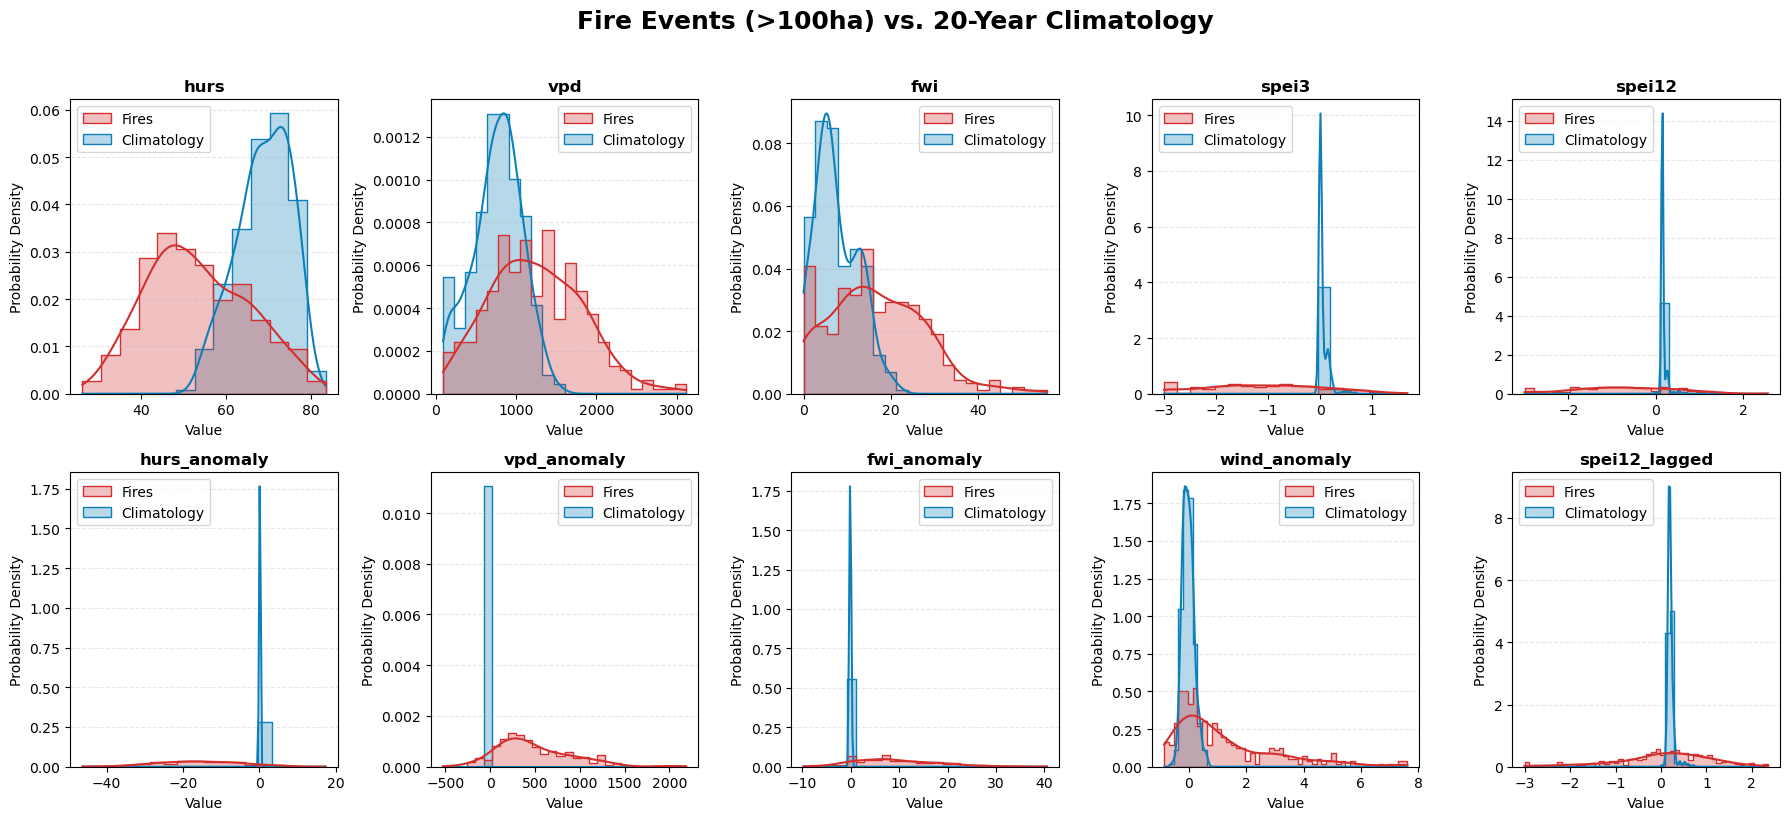

In [23]:
# 1. Prepare the data
df_plot = fires.copy()
df_plot = df_plot[df_plot["area_ha"] >= 100]  # Filter for fires > 100ha

# 2. Identify pairs
var_names = [
    "hurs",
    "vpd",
    "fwi",
    "spei3",
    "spei12",
    "hurs_anomaly",
    "vpd_anomaly",
    "fwi_anomaly",
    "wind_anomaly",
    "spei12_lagged",
]

# 3. Setup Grid
n_cols = 5
n_rows = int(np.ceil(len(var_names) / n_cols))
fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, 4 * n_rows))
axes = axes.flatten()

for i, var in enumerate(var_names):
    ax = axes[i]

    # Selecting the specific actual and clim columns
    actual_col = var
    clim_col = f"{var}_clim"

    # Melt specifically for this variable to avoid huge memory usage
    temp_df = df_plot[["fire_id", actual_col, clim_col]].melt(
        id_vars="fire_id", var_name="Group", value_name="Value"
    )

    # Map for clean legend
    temp_df["Group"] = temp_df["Group"].map(
        {actual_col: "Fires", clim_col: "Climatology"}
    )

    # Plot
    sns.histplot(
        data=temp_df,
        x="Value",
        hue="Group",
        stat="density",  # This makes the area under each curve = 1
        common_norm=False,  # This ensures both groups are normalized independently
        element="step",
        kde=True,
        palette={
            "Fires": "#d32f2f",
            "Climatology": "#0E80B9",
        },
        alpha=0.3,
        ax=ax,
    )

    ax.set_title(f"{var}", fontsize=12, fontweight="bold")
    ax.set_xlabel("Value")
    ax.set_ylabel("Probability Density")
    ax.grid(axis="y", linestyle="--", alpha=0.3)

    if ax.get_legend() is not None:
        ax.get_legend().set_title("")

# Cleanup
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.suptitle(
    "Fire Events (>100ha) vs. 20-Year Climatology",
    fontsize=18,
    y=1.02,
    fontweight="bold",
)
plt.tight_layout()
plt.show()

In [24]:
# 1. Use your fires GeoDataFrame/DataFrame directly
# Every row in your new geojson is an actual fire event.
df_fires = fires.copy()

# CHOOSE YOUR FEATURE HERE:
# Options: 'fwi', 'tas', 'spei3', etc.
# Or the anomaly version: 'fwi_anomaly' (if you calculated it in the previous step)

feature_to_plot = "fwi"
log_y = True  # Set to True if you want to use a logarithmic scale for the y-axis (common for fire size distributions)
filter_large_fires = True  # Set to True to focus on larger fires (e.g., area_ha > 100)
if filter_large_fires:
    df_fires = df_fires[df_fires['area_ha']>=100]
    
# 2. Calculate the correlation for the title
# Use area_ha (the column we created earlier) or "area"
y_axis_col = "area_ha"
valid_data = df_fires[[feature_to_plot, y_axis_col]].dropna()

if len(valid_data) > 1:
    corr = valid_data[feature_to_plot].corr(valid_data[y_axis_col])
else:
    corr = np.nan

# 3. Create the interactive scatter plot
fig = px.scatter(
    df_fires,
    x=feature_to_plot,
    y=y_axis_col,
    hover_data=["fire_id", "year"],  # Added year for better context
    log_y=log_y,
    title=f"{feature_to_plot.upper()} vs Burned Area (Pearson r = {corr:.3f})",
    labels={
        y_axis_col: "Area (Hectares)",
        feature_to_plot: f"Actual {feature_to_plot.upper()} on Fire Day",
    },
    color_discrete_sequence=["#d32f2f"],
)

# 4. Stylistic Improvements
fig.update_layout(
    template="plotly_white",
    xaxis_title=f"Actual {feature_to_plot.upper()}",
    yaxis_title="Burned Area (Hectares, Log Scale)",
    hoverlabel=dict(bgcolor="white", font_size=12),
)

# 5. Add a trendline (Optional but helpful for visualization)
# If you want a trendline, uncomment the line below:
fig.update_traces(marker=dict(size=8, opacity=0.6))

fig.show()

## 5. Influence of Biophysical Variables in Fires

Because meteorological variables alone cannot fully explain fire behavior, we must also consider the physical landscape. In this section, historical fire perimeters are plotted alongside key biophysical variables, including pre-fire biomass (fuel load), land cover, and topography. Below, we examine two specific case studies where the final extent of the fire is dictated by the complex interaction between these local terrain features and extreme weather conditions.

### 5.1. Biomass

Biomass naturally acts as the primary fuel source for wildfires, directly driving their intensity and spread. In this case study, the perimeter of the burn scar aligns almost perfectly with areas of high biomass volume recorded in 1985. Combined with severe, prolonged drought conditions (indicated by intensely low SPEI-3 and SPEI-12 values), this dense fuel load created the ideal environment for a massive fire event.

![Example 1](../inputs/example1.png)

### 5.2. Elevation

In this example, topography acted as a critical physical barrier. A sharp increase in elevation prevented the fire from spreading further north, despite a large volume of available biomass in that direction. Additionally, the burned area is situated on a south-facing slope (aspect). In the Northern Hemisphere, these slopes receive maximum solar radiation, which aggressively dries out the vegetation. Combined with three months of severe drought (low SPEI-3) and a very high FWI value, the area was highly volatile and sustained an intense fire event.

![Example 2](../inputs/example2.png)

The ultimate goal of this analysis is to inform a predictive wildfire model. We have demonstrated that final fire extent is a complex product of extreme weather anomalies, accumulated drought, fuel density, and topographical barriers.